In [162]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [163]:
df = pd.read_csv('../results/result.csv')
df = df[df.run >= 3].copy()
df['speed'] = df['sim-cycles'] / df['time']
df['ipc'] = df['instructions'] / df['cycles']
df['MPKI'] = df['cache-misses'] / df['instructions'] * 1000
df

,simulator,benchmark,sim-cycles,run,time,all_data_cache_accesses,cache-misses,cycles,instructions,speed,ipc,MPKI
3,circt-verilator-4,Gemmini,10000,3,76433,996160869.0,9484927.0,1.394256e+09,3.798411e+09,0.130834,2.724329,2.497077
4,circt-verilator-4,Gemmini,10000,4,76314,995458044.0,9113396.0,1.391149e+09,3.798185e+09,0.131038,2.730250,2.399408
5,circt-verilator-4,Gemmini,10000,5,77655,997142830.0,9277535.0,1.414211e+09,3.799924e+09,0.128775,2.686956,2.441505
6,circt-verilator-4,Gemmini,10000,6,76079,994252546.0,9518597.0,1.385430e+09,3.798004e+09,0.131442,2.741390,2.506211
7,circt-verilator-4,Gemmini,10000,7,78551,995604641.0,9132972.0,1.430477e+09,3.800508e+09,0.127306,2.656812,2.403093
...,...,...,...,...,...,...,...,...,...,...,...,...
1335,essent,FMUL,10000,5,1045918,787679738.0,59855817.0,2.299251e+09,1.571046e+09,0.009561,0.683286,38.099341
1336,essent,FMUL,10000,6,1044932,787663697.0,58145089.0,2.296943e+09,1.571046e+09,0.009570,0.683973,37.010430
1337,essent,FMUL,10000,7,1044698,788301405.0,57959793.0,2.296959e+09,1.571046e+09,0.009572,0.683968,36.892487
1338,essent,FMUL,10000,8,1043739,788058926.0,57710025.0,2.294419e+09,1.571046e+09,0.009581,0.684725,36.733504


# Speedup

In [164]:
piv = df.pivot_table(values='speed', index='benchmark', columns='simulator')
order = [
  'SHA256',
  'StreamComp',
  'FMUL',
  'FPU',
  'Gemmini',
  'SIGMA',
  'GEMM',
  'Conv2D',
  'RISCVMini',
  'RocketCore',
  'SodorCore'
]
sim_order = [
  'circt-verilator', 'verilator-1', 'verilator-2', 'verilator-4', 'ksim', 'essent', 'repcut-1', 'repcut-2', 'repcut-4', 'vcs'
]
baseline_name = 'circt-verilator'
baseline = piv[baseline_name].copy()
for col in piv:
  piv[col] /= baseline
piv = piv.stack().loc[order].reset_index(name='speedup')
piv = piv.set_index('benchmark').reset_index()
def mark_npos(bar, y, *args, **kws):
  npos = []
  for c in bar.containers:
    for child in c.get_children():
      if np.isnan(child.get_height()):
        center = child.get_x() + child.get_width() / 2
        npos.append(center)
  xlim = plt.xlim()
  plt.plot(npos, np.full(len(npos), y), *args, **kws)
  plt.xlim(xlim)

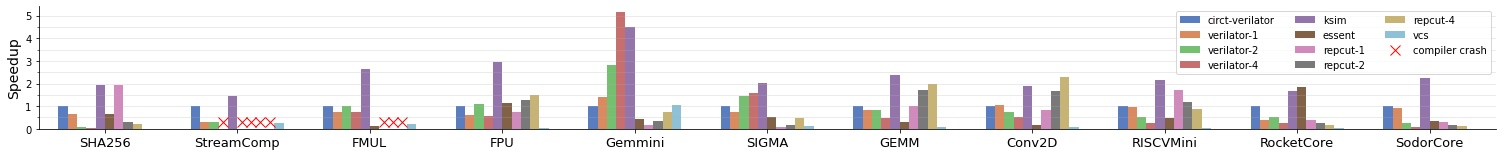

In [165]:
plt.figure(figsize=(22, 2.5))
bar = sns.barplot(
  data=piv,
  x='benchmark', y='speedup',
  hue='simulator', hue_order=sim_order,
  palette='muted',
  width=0.7,
)
# set_hatch(bar)
# for c in bar.containers:
#   bar.bar_label(c, fmt='$%.1f$', fontsize=10)
mark_npos(bar, 0.3, 'rx', markersize=10, label='compiler crash')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[1:] + handles[:1], labels[1:] + labels[:1], loc='upper right', ncol=3)
# plt.xticks(fontsize=13, rotation=-15, ha='left')
plt.xticks(fontsize=13)
plt.xlabel(None)
# plt.ylim([0, 5])
plt.ylabel('Speedup', fontsize=14)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0))
ax.yaxis.set_minor_locator(ticker.IndexLocator(base=0.5, offset=0))
plt.grid(axis='y', alpha=0.3)
plt.grid(axis='y', which='minor', alpha=0.3)
sns.despine()
plt.subplots_adjust(left=0.05, right=0.97, bottom=0.2)
plt.draw()

In [166]:
piv_abs = df.pivot_table(values='speed', columns='simulator', index='benchmark', aggfunc='mean')
baseline_name = 'circt-verilator'
baseline = piv_abs[baseline_name].copy()
piv = piv_abs.apply(lambda x: x / baseline)
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.2f}')

simulator,circt-verilator,circt-verilator-2,circt-verilator-4,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,1.00,1.39,1.09,0.16,1.88,0.84,1.66,2.27,0.08,0.96,1.07,0.74,0.53
FMUL,1.00,2.20,2.03,0.11,2.62,nan,nan,nan,0.21,0.74,0.76,1.01,0.75
FPU,1.00,1.97,1.37,1.13,2.97,0.74,1.29,1.51,0.04,0.57,0.61,1.09,0.55
GEMM,1.00,1.08,0.70,0.29,2.38,1.02,1.70,1.97,0.06,0.76,0.81,0.81,0.47
Gemmini,1.00,4.56,7.55,0.45,4.48,0.18,0.36,0.72,1.05,1.41,1.42,2.83,5.15
RISCVMini,1.00,0.85,0.24,0.48,2.17,1.72,1.19,0.86,0.02,0.80,0.98,0.52,0.27
RocketCore,1.00,1.14,0.87,1.86,1.66,0.37,0.26,0.18,0.05,0.39,0.41,0.54,0.26
SHA256,1.00,0.25,0.08,0.67,1.93,1.94,0.32,0.19,0.00,0.63,0.65,0.09,0.03
SIGMA,1.00,2.69,3.38,0.53,2.03,0.08,0.15,0.47,0.12,0.68,0.73,1.45,1.59


# IPC

In [167]:
piv = df.pivot_table(values='ipc', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_max(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,circt-verilator-2,circt-verilator-4,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,1.775,0.559,0.274,1.111,3.016,1.802,1.502,1.038,2.507,1.803,1.881,0.618,0.273
FMUL,1.884,1.017,0.519,0.683,2.944,nan,nan,nan,2.493,2.095,2.115,0.974,0.419
FPU,3.590,1.668,0.661,2.583,3.566,1.848,1.624,0.951,2.529,2.767,2.777,1.188,0.377
GEMM,1.732,0.423,0.175,1.885,2.957,2.126,1.442,0.876,2.524,1.459,1.449,0.613,0.226
Gemmini,2.941,3.206,2.718,0.527,3.301,0.529,0.523,0.521,2.468,2.709,2.715,2.624,2.384
RISCVMini,1.963,0.527,0.191,2.461,3.300,2.622,1.211,0.580,2.518,2.197,2.272,0.612,0.252
RocketCore,2.394,0.756,0.343,2.549,2.986,1.499,0.818,0.507,2.517,2.409,2.411,0.648,0.230
SHA256,2.813,0.423,0.173,3.230,3.332,2.824,0.448,0.230,2.533,2.762,2.793,0.383,0.161
SIGMA,3.236,2.108,1.353,1.347,3.401,0.511,0.497,0.759,2.495,2.181,2.254,1.993,1.148


# Cycles

In [161]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [123]:
piv = df.pivot_table(values='cycles', columns='simulator', index='benchmark', aggfunc='mean')
# piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,circt-verilator-2,circt-verilator-4,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,90.3 M,288.7 M,731.9 M,592.1 M,51.6 M,114.2 M,116.0 M,169.1 M,910.8 M,94.0 M,90.1 M,255.6 M,721.9 M
FMUL,250.5 M,489.9 M,1.1 G,2.3 G,97.6 M,None,None,None,2.8 G,342.8 M,339.6 M,506.9 M,1.4 G
FPU,46.4 M,109.8 M,311.6 M,46.6 M,18.4 M,69.5 M,80.5 M,144.7 M,694.8 M,85.0 M,84.7 M,95.0 M,373.6 M
GEMM,66.8 M,281.1 M,866.9 M,260.4 M,31.1 M,70.9 M,86.0 M,147.9 M,910.1 M,89.3 M,89.9 M,178.6 M,616.2 M
Gemmini,1.3 G,1.2 G,1.4 G,2.9 G,283.7 M,7.1 G,7.1 G,7.1 G,10.6 G,896.9 M,895.1 M,899.7 M,989.4 M
RISCVMini,20.8 M,115.9 M,815.4 M,50.5 M,12.2 M,14.8 M,40.9 M,119.6 M,672.0 M,25.8 M,25.0 M,91.5 M,340.8 M
RocketCore,51.5 M,208.6 M,544.0 M,265.4 M,35.0 M,151.3 M,437.6 M,1.3 G,928.9 M,139.3 M,139.2 M,211.9 M,866.5 M
SHA256,4.8 M,53.8 M,342.2 M,6.2 M,3.0 M,2.9 M,32.8 M,75.8 M,621.1 M,6.4 M,6.4 M,75.0 M,395.8 M
SIGMA,152.6 M,242.9 M,391.8 M,300.5 M,78.9 M,2.1 G,2.1 G,1.4 G,884.2 M,225.9 M,218.5 M,219.8 M,399.4 M


# Instructions

In [105]:
def format_scled(c):
  units = ['', ' k', ' M', ' G', ' T', ' E']
  for unit in units:
    if c < 1000:
      return f'{c:.1f}{unit}'
    c /= 1000

In [106]:
piv = df.pivot_table(values='instructions', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format(format_scled)

simulator,circt-verilator,circt-verilator-2,circt-verilator-4,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,160.1 M,161.5 M,200.6 M,674.6 M,155.5 M,205.9 M,174.2 M,175.5 M,2.3 G,169.4 M,169.4 M,157.6 M,197.0 M
FMUL,472.0 M,498.3 M,546.0 M,223.6 M,287.4 M,None,None,None,3.6 G,718.2 M,718.2 M,493.5 M,571.6 M
FPU,166.6 M,183.1 M,206.0 M,28.2 M,65.6 M,128.4 M,130.6 M,136.3 M,1.7 G,235.2 M,235.2 M,112.9 M,140.7 M
GEMM,115.8 M,118.8 M,151.9 M,518.5 M,92.1 M,150.6 M,124.0 M,129.5 M,2.4 G,130.2 M,130.2 M,109.5 M,139.2 M
Gemmini,3.7 G,3.7 G,3.8 G,1.2 G,936.7 M,3.8 G,3.7 G,3.7 G,24.4 G,2.4 G,2.4 G,2.4 G,2.4 G
RISCVMini,40.8 M,61.1 M,155.4 M,14.5 M,40.2 M,38.7 M,49.5 M,68.0 M,1.7 G,56.7 M,56.7 M,56.0 M,85.9 M
RocketCore,123.3 M,157.7 M,186.8 M,124.8 M,104.4 M,226.7 M,357.6 M,639.8 M,2.2 G,335.5 M,335.5 M,137.2 M,199.6 M
SHA256,13.4 M,22.7 M,59.3 M,4.2 M,9.9 M,8.3 M,11.3 M,16.9 M,1.6 G,17.8 M,17.8 M,28.8 M,63.7 M
SIGMA,493.7 M,510.7 M,530.0 M,397.0 M,268.2 M,1.1 G,1.1 G,1.0 G,2.0 G,492.6 M,492.6 M,438.0 M,458.5 M


# MPKI

In [107]:
piv = df.pivot_table(values='MPKI', columns='simulator', index='benchmark', aggfunc='mean')
piv.loc['Average'] = piv.mean()
styled = piv.style
styled.highlight_min(color='green', axis=1).format('{:.3f}')

simulator,circt-verilator,circt-verilator-2,circt-verilator-4,essent,ksim,repcut-1,repcut-2,repcut-4,vcs,verilator,verilator-1,verilator-2,verilator-4
benchmark,,,,,,,,,,,,,
Conv2D,0.254,45.583,71.785,1.776,0.142,0.111,5.832,10.630,2.157,0.271,0.177,40.634,75.992
FMUL,0.092,1.853,5.811,0.407,0.077,nan,nan,nan,19.716,0.080,0.058,3.687,12.897
FPU,0.177,5.577,12.775,0.668,0.281,0.152,2.846,6.308,1.130,0.123,0.117,7.511,23.766
GEMM,0.261,64.238,140.006,0.311,0.201,0.137,12.597,21.328,1.657,0.225,0.222,40.278,95.722
Gemmini,14.433,4.809,2.439,51.672,7.173,47.726,32.209,3.291,5.230,7.170,7.488,2.470,4.490
RISCVMini,0.698,24.007,60.458,1.333,0.463,0.484,6.829,12.985,1.190,0.563,0.468,16.857,41.383
RocketCore,0.234,12.779,28.098,0.185,0.175,0.100,1.677,2.128,1.420,0.090,0.087,20.580,52.713
SHA256,1.860,22.197,46.616,5.055,1.746,2.098,18.452,34.379,1.187,1.433,1.447,28.823,66.153
SIGMA,0.073,3.123,6.784,0.478,0.079,15.613,0.748,1.141,1.300,0.103,0.072,3.358,8.048
